<a href="https://colab.research.google.com/github/NataliaGon/kpi/blob/main/new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from urllib.parse import urlparse
from google.colab import drive
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import Normalizer
from scipy.sparse import csr_matrix, hstack
from scipy.sparse import hstack, csr_matrix
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA


In [93]:
drive.mount('/content/gdrive')
df=pd.read_csv('gdrive/My Drive/Geneva forum/ML/green-spots6.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Fields

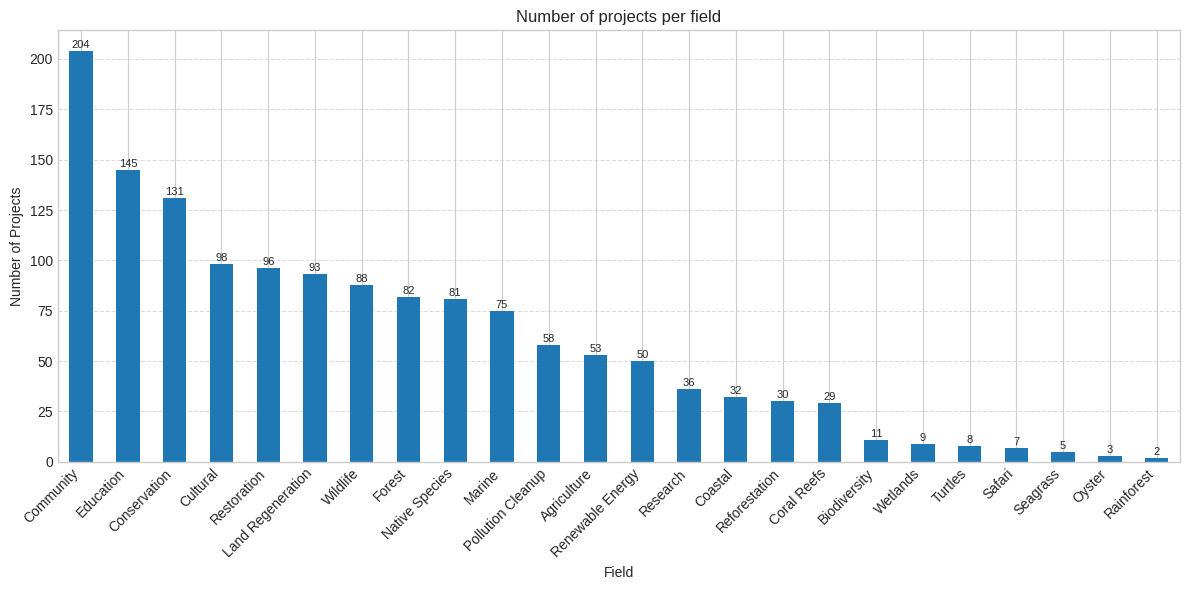

In [103]:
all_fields = []

for row in df["fields"].dropna():
    if isinstance(row, list):
        parts = row
    else:
        parts = str(row).split(",")

    for f in parts:
        name = str(f).strip()
        if name:
            all_fields.append(name.lower())

field_counts = pd.Series(all_fields).value_counts()

field_counts.index = field_counts.index.str.title()

plt.figure(figsize=(12, 6))

ax = field_counts.plot(kind="bar")

plt.title("Number of projects per field")
plt.xlabel("Field")
plt.ylabel("Number of Projects")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()


for i, v in enumerate(field_counts.values):
    ax.text(
        i,
        v + 0.5,
        str(v),
        ha="center",
        va="bottom",
        fontsize=8,
        # rotation=90
    )

plt.show()

# Countries

['argentina', 'australia', 'australia', 'australia', 'australia', 'australia', 'australia', 'australia', 'australia', 'australia', 'australia', 'australia', 'australia', 'australia', 'australia', 'australia', 'australia', 'australia', 'australia', 'bahamas', 'belize', 'belize', 'bhutan', 'bhutan', 'botswana', 'botswana', 'botswana', 'botswana', 'brazil', 'brazil', 'cambodia', 'cambodia', 'cambodia', 'canada', 'canada', 'canada', 'canada', 'canada', 'canada', 'canada', 'cape verde', 'colombia', 'bahamas', 'chile', 'colombia', 'colombia', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'costa rica', 'cyprus', 'cyprus', 'denmark', 'denmark', 'denmark', 'ecuador', 'ecuador', 'egypt', 'fiji', 'fiji', 'finland', 'finland', 'france', 'france', 'ecuador', 'guyana', 'iceland', 'ic

/tmp/ipython-input-897299907.py:101: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


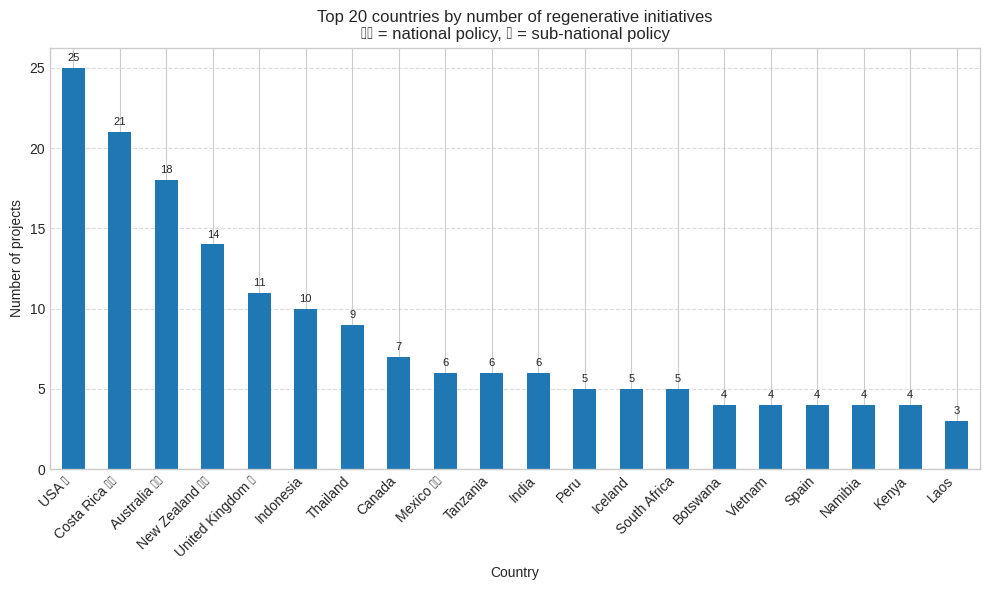

In [104]:

def format_country(name: str) -> str:
    n = str(name).strip().lower()
    base = n.title()

    exceptions = {
        "usa": "USA",
        "uk": "UK",
        "uae": "UAE",
        "eu": "EU",
        "united kingdom": "United Kingdom",
    }
    if n in exceptions:
        return exceptions[n]
    return base



all_countries = []

for row in df["country"].dropna():

    if isinstance(row, list):
        parts = row
    else:
        parts = str(row).split(",")

    for c in parts:
        name = str(c).strip()
        if name:
            all_countries.append(name.lower())

print(all_countries)


country_counts = pd.Series(all_countries).value_counts()
print(country_counts)


stats = (
    country_counts
    .rename("projects")
    .reset_index()
    .rename(columns={"index": "country_norm"})
)

policy_national = {
    "costa rica",
    "new zealand",
    "palau",
    "australia",
    "slovenia",
    "finland",
    "sweden",
    "bhutan",
    "mexico",
}

policy_partial = {
    "usa",
    "united kingdom",
}

def policy_level(country_norm):
    if country_norm in policy_national:
        return 2   # strong / national
    if country_norm in policy_partial:
        return 1   # partial / sub-national
    return 0       # none

stats["policy_level"] = stats["country_norm"].apply(policy_level)




def label_with_star(row):
    base = format_country(row["country_norm"])
    if row["policy_level"] == 2:
        return base + " ★★"   # national
    if row["policy_level"] == 1:
        return base + " ★"    # partial
    return base


top20 = stats.nlargest(20, "projects").copy()
top20["label"] = top20.apply(label_with_star, axis=1)
top20 = top20.set_index("label")


plt.figure(figsize=(10, 6))
ax = top20["projects"].plot(kind="bar")

plt.title(
    "Top 20 countries by number of regenerative initiatives\n"
    "★★ = national policy, ★ = sub-national policy"
)

plt.xlabel("Country")
plt.ylabel("Number of projects")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()


for i, v in enumerate(top20["projects"].values):
    ax.text(
        i,
        v + 0.3,
        str(v),
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.show()


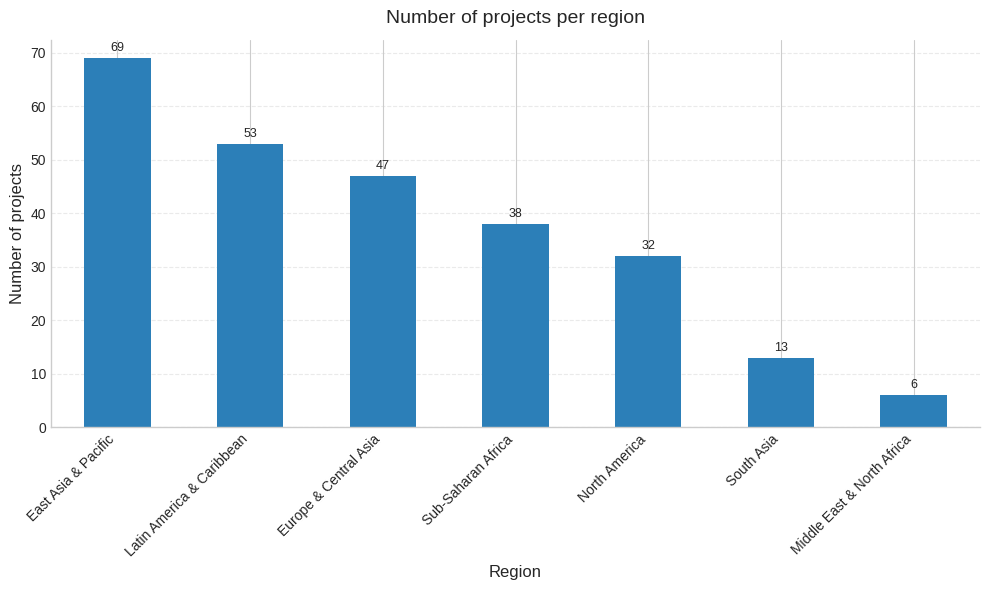

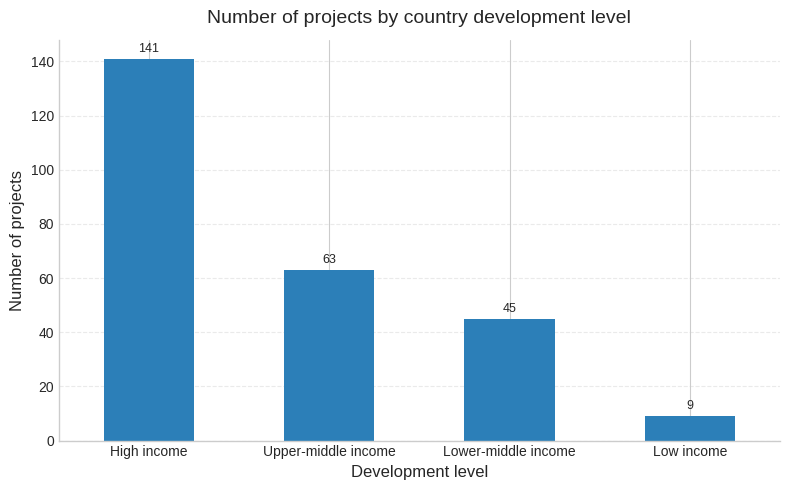

In [105]:


plt.style.use("seaborn-v0_8-whitegrid")
BAR_COLOR = "#2c7fb8"


def add_value_labels(ax, fontsize=9, offset=3):
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(
            f"{int(height)}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, offset),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=fontsize,
        )



all_regions = []
for row in df["region"].dropna():
    if isinstance(row, list):
        parts = row
    else:
        parts = str(row).split(",")
    for r in parts:
        name = str(r).strip().rstrip(".")
        if name:
            all_regions.append(name)

region_counts = pd.Series(all_regions).value_counts()

fig, ax = plt.subplots(figsize=(10, 6))
region_counts.plot(kind="bar", ax=ax, color=BAR_COLOR)

ax.set_title("Number of projects per region", fontsize=14, pad=12)
ax.set_xlabel("Region", fontsize=12)
ax.set_ylabel("Number of projects", fontsize=12)

ax.set_axisbelow(True)
ax.grid(axis="y", linestyle="--", alpha=0.4)

ax.tick_params(axis="x", rotation=45)
for label in ax.get_xticklabels():
    label.set_horizontalalignment("right")

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

add_value_labels(ax, fontsize=9, offset=3)
fig.tight_layout()
plt.show()




all_levels = []
for row in df["country_development_level"].dropna():
    if isinstance(row, list):
        parts = row
    else:
        parts = str(row).split(",")
    for lvl in parts:
        name = str(lvl).strip()
        if name:
            all_levels.append(name)

mapping = {
    "high income": "High income",
    "upper income": "Upper-middle income",
    "up income": "Upper-middle income",
    "upper-middle income": "Upper-middle income",
    "upper middle income": "Upper-middle income",
    "lower income": "Lower-middle income",
    "lower-middle income": "Lower-middle income",
    "lower middle income": "Lower-middle income",
    "low income": "Low income",
}

normalized_levels = [
    mapping.get(level.lower(), level.title()) for level in all_levels
]

dev_counts = pd.Series(normalized_levels).value_counts()
order = ["High income", "Upper-middle income", "Lower-middle income", "Low income"]
dev_counts = dev_counts.reindex(order).dropna()

fig, ax = plt.subplots(figsize=(8, 5))
dev_counts.plot(kind="bar", ax=ax, color=BAR_COLOR)

ax.set_title("Number of projects by country development level", fontsize=14, pad=12)
ax.set_xlabel("Development level", fontsize=12)
ax.set_ylabel("Number of projects", fontsize=12)

ax.set_axisbelow(True)
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.tick_params(axis="x", rotation=0)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

add_value_labels(ax, fontsize=9, offset=3)
fig.tight_layout()
plt.show()


# Correlation policy/projects

In [106]:

policy_countries = {
    "costa rica",
    "new zealand",
    "palau",
    "australia",
    "slovenia",
    "finland",
    "sweden",
    "bhutan",
    "mexico",
    "usa",
    "united kingdom",
}


stats = (
    country_counts
    .rename("projects")
    .reset_index()
    .rename(columns={"index": "country_raw"})
)


stats["country_norm"] = stats["country_raw"].str.strip().str.lower()


stats["has_policy"] = stats["country_norm"].isin(policy_countries).astype(int)



stats["country_label"] = stats["country_norm"].apply(format_country)

stats.head()


,country_raw,projects,country_norm,has_policy,country_label
0,usa,25,usa,1,USA
1,costa rica,21,costa rica,1,Costa Rica
2,australia,18,australia,1,Australia
3,new zealand,14,new zealand,1,New Zealand
4,united kingdom,11,united kingdom,1,United Kingdom


In [107]:
corr = stats["projects"].corr(stats["has_policy"])
print("Correlation between number of projects and having policy:", corr)


Correlation between number of projects and having policy: 0.5537623116956317


/tmp/ipython-input-3204416040.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


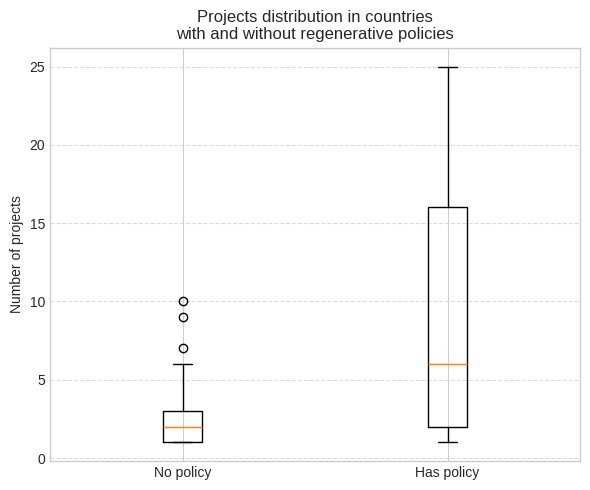

In [108]:
plt.figure(figsize=(6, 5))

data_no_policy = stats.loc[stats["has_policy"] == 0, "projects"]
data_policy    = stats.loc[stats["has_policy"] == 1, "projects"]

plt.boxplot(
    [data_no_policy, data_policy],
    labels=["No policy", "Has policy"]
)

plt.title("Projects distribution in countries\nwith and without regenerative policies")
plt.ylabel("Number of projects")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# WEBSITE DOMAIN EXTRACTION & VISUALIZATION

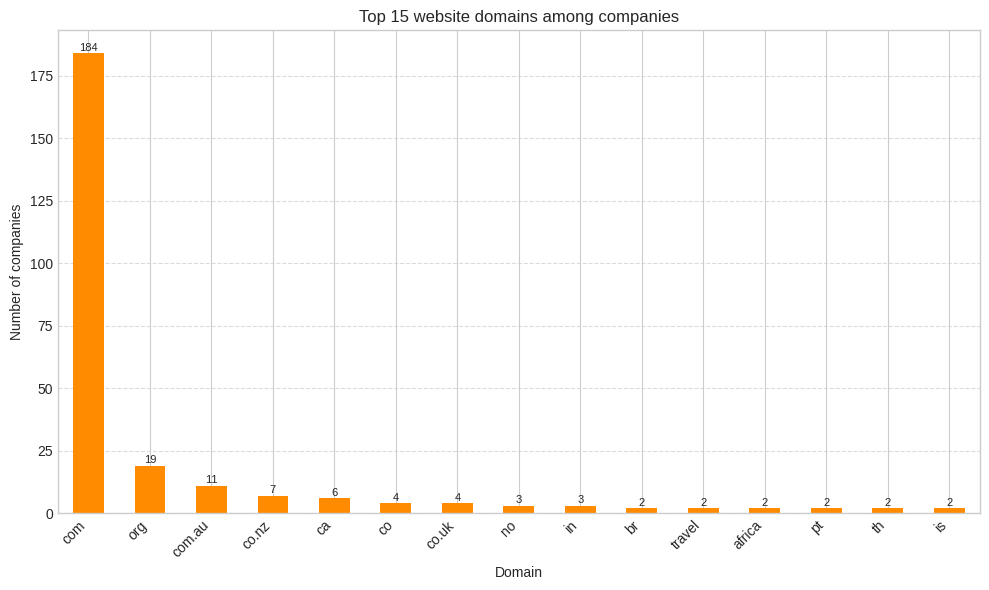

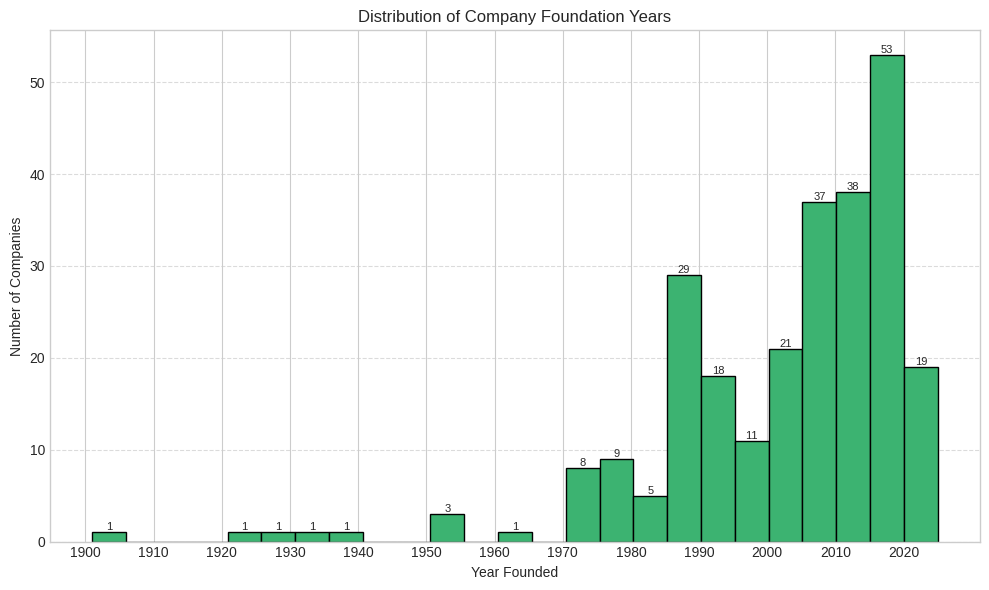

Earliest company: 1901.0
Latest company: 2025.0
Median founding year: 2008

Most common website domains:
 domain
com       184
org        19
com.au     11
co.nz       7
ca          6
co          4
co.uk       4
no          3
in          3
br          2
Name: count, dtype: int64


In [109]:
df["company's website"] = df["company's website"].replace(["0", 0, "", " "], pd.NA)
df["company's foundation year"] = df["company's foundation year "].replace(["0", 0, "", " "], pd.NA)


def extract_domain(url):
    if pd.isna(url) or not isinstance(url, str) or len(url.strip()) == 0:
        return None
    try:
        netloc = urlparse(url).netloc.lower()
        if netloc.startswith("www."):
            netloc = netloc[4:]
        parts = netloc.split(".")

        if len(parts) >= 2:
            if parts[-1] in ["uk", "au", "nz"]:
                return ".".join(parts[-2:])
            return parts[-1]
        return netloc
    except Exception:
        return None

df["domain"] = df["company's website"].apply(extract_domain)
domain_counts = df["domain"].dropna().value_counts()

plt.figure(figsize=(10,6))
ax = domain_counts.head(15).plot(kind="bar", color="darkorange")
plt.title("Top 15 website domains among companies")
plt.xlabel("Domain")
plt.ylabel("Number of companies")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()


for i, v in enumerate(domain_counts.head(15).values):
    ax.text(
        i,
        v + 0.2,
        str(v),
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.show()


#  FOUNDATION YEAR CLEANING & VISUALIZATION


def extract_year(value):
    """Extract 4-digit year if valid"""
    if pd.isna(value):
        return None
    text = str(value)
    match = re.search(r"(19|20)\d{2}", text)
    return int(match.group()) if match else None

df["year_founded"] = df["company's foundation year "].apply(extract_year)

# Keep valid range (1900–2025)
df_years = df[df["year_founded"].between(1900, 2025, inclusive="both")]

plt.figure(figsize=(10,6))

# ax2 is the Axes object you can control
ax2 = df_years["year_founded"].hist(bins=25, color="mediumseagreen", edgecolor="black")

plt.title("Distribution of Company Foundation Years")
plt.xlabel("Year Founded")
plt.ylabel("Number of Companies")
plt.grid(axis="y", linestyle="--", alpha=0.7)


years = sorted(df_years["year_founded"].unique())

start = (min(years) // 5) * 5      # round DOWN to nearest 5
end   = (max(years) // 5) * 5      # round DOWN to nearest 5

ticks = np.arange(start, end + 1, 10)
# ticks = years[::11]
ax2.set_xticks(ticks)
ax2.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))

plt.tight_layout()


for p in ax2.patches:
    height = p.get_height()
    if height > 0:
        x = p.get_x() + p.get_width() / 2
        ax2.text(
            x,
            height,
            str(int(height)),
            ha="center",
            va="bottom",
            fontsize=8,
        )

plt.show()


#  SUMMARY

print("Earliest company:", df_years["year_founded"].min())
print("Latest company:", df_years["year_founded"].max())
print("Median founding year:", int(df_years["year_founded"].median()))
print("\nMost common website domains:\n", domain_counts.head(10))


# Clusterization

Sample cleaned fields:
0           [wildlife, native species]
1    [wetlands, wildlife, agriculture]
2        [agriculture, native species]
3             [marine, native species]
4                                   []
Name: fields_clean, dtype: object
Sample cleaned regions:
0    [latin america & caribbean]
1          [east asia & pacific]
2          [east asia & pacific]
3          [east asia & pacific]
4          [east asia & pacific]
Name: regions_clean, dtype: object
Sample cleaned dev levels:
0    [upper middle income]
1            [high income]
2            [high income]
3            [high income]
4            [high income]
Name: dev_clean, dtype: object
X_fields shape: (273, 5)
field classes: ['forest' 'marine' 'unknown' 'wetlands' 'wildlife']
X_regions shape: (273, 7)
region classes: ['east asia & pacific' 'europe & central asia' 'latin america & caribbean'
 'middle east & north africa' 'north america' 'south asia'
 'sub-saharan africa']
X_dev shape: (273, 4)
dev classes: ['hig

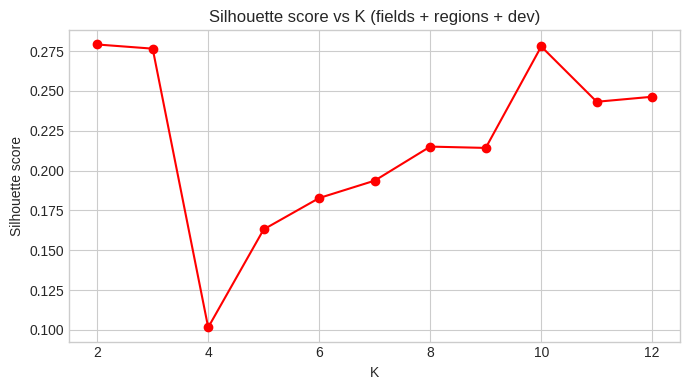


 Best K by silhouette: 2


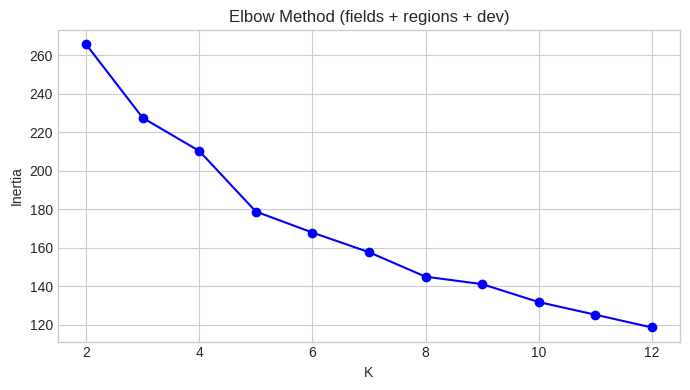


Cluster sizes:
cluster_all
0    143
1    130
Name: count, dtype: int64

==================== CLUSTER SUMMARIES ====================


--- CLUSTER 0 ---
Top fields:
forest            78
native species    55
agriculture       48
wildlife          38
marine            31
reforestation     27
coastal           12
Name: count, dtype: int64

Top regions:
east asia & pacific          41
latin america & caribbean    39
sub-saharan africa           27
europe & central asia        20
north america                18
Name: count, dtype: int64

Top development levels:
high income            77
upper middle income    38
lower middle income    31
low income              8
Name: count, dtype: int64

Total projects: 143
------------------------------------------------------

--- CLUSTER 1 ---
Top fields:
marine               40
wildlife             21
coral reefs          20
pollution cleanup    19
native species       16
coastal              13
seagrass              5
Name: count, dtype: int64

Top r

In [116]:

# FIELD DEFINITIONS (STRONG + NOISE)


strong_fields = {
    "marine",
    "coastal",
    "coral reefs",
    "seagrass",
    "turtles",
    "oyster",
    "wildlife",
    "native species",
    "wetlands",
    "rainforest",
    "forest",
    "reforestation",
    "pollution cleanup",
    "agriculture",
    "safari",
}

noise_fields = {
    "community",
    "cultural",
    "education",
    "conservation",
    "research",
    "restoration",
    "land regeneration",
    "renewable energy",
    "biodiversity",
}


# CLEAN + FILTER FIELDS (KEEP STRONG, DROP NOISE)

def clean_and_filter_fields(x: str):

    if not isinstance(x, str):
        return []

    parts = [p.strip().lower() for p in x.split(",") if p.strip()]

    cleaned = []
    for f in parts:
        if f in noise_fields:
            continue

        if f in strong_fields:
            cleaned.append(f)

    cleaned = list(dict.fromkeys(cleaned))

    # optionally limit to top N strongest signals per project
    return cleaned[:3]

# apply cleaning to original df["fields"]
df["fields_clean"] = (
    df["fields"]
      .fillna("")
      .astype(str)
      .apply(clean_and_filter_fields)
)

print("Sample cleaned fields:")
print(df["fields_clean"].head())



#  GENERIC CLEANER FOR COMMA-SEPARATED COLUMNS


def clean_multi_simple(x: str):
    """
    For region and country_development_level:
    - splits by comma
    - strips spaces
    - lowercases
    """
    if not isinstance(x, str):
        return []
    return [p.strip().lower() for p in x.split(",") if p.strip()]

# region may be comma-separated: "east asia & pacific, europe"
df["regions_clean"] = (
    df["region"]
      .fillna("")
      .astype(str)
      .apply(clean_multi_simple)
)

# country_development_level may be comma-separated too
df["dev_clean"] = (
    df["country_development_level"]
      .fillna("")
      .astype(str)
      .apply(clean_multi_simple)
)
df["group_clean"] = (
    df["ecosystem_group"]
      .fillna("")
      .astype(str)
      .apply(clean_multi_simple)
)


print("Sample cleaned regions:")
print(df["regions_clean"].head())
print("Sample cleaned dev levels:")
print(df["dev_clean"].head())




mlb_fields = MultiLabelBinarizer()
X_fields = mlb_fields.fit_transform(df["group_clean"])
print("X_fields shape:", X_fields.shape)
print("field classes:", mlb_fields.classes_)



mlb_regions = MultiLabelBinarizer()
X_regions = mlb_regions.fit_transform(df["regions_clean"])
print("X_regions shape:", X_regions.shape)
print("region classes:", mlb_regions.classes_)


mlb_dev = MultiLabelBinarizer()
X_dev = mlb_dev.fit_transform(df["dev_clean"])
print("X_dev shape:", X_dev.shape)
print("dev classes:", mlb_dev.classes_)






w_fields = 1.0      # strongest semantic signal
w_regions = 0.7     # geography
w_dev = 0.5         # development level

X = hstack(
    [
        csr_matrix(X_fields) * w_fields,
        csr_matrix(X_regions) * w_regions,
        csr_matrix(X_dev) * w_dev,
    ],
    format="csr",
)

print("Final X shape:", X.shape)



# SILHOUETTE ANALYSIS


sil_scores = []
K_values = range(2, 13)

for k in K_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels, metric="cosine")
    sil_scores.append(score)
    print(f"K={k}: silhouette={score:.3f}")

plt.figure(figsize=(7, 4))
plt.plot(K_values, sil_scores, "o-r")
plt.title("Silhouette score vs K (fields + regions + dev)")
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.tight_layout()
plt.show()

best_k_sil = K_values[sil_scores.index(max(sil_scores))]
print("\n Best K by silhouette:", best_k_sil)



# ELBOW METHOD


inertias = []
for k in K_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K_values, inertias, "o-b")
plt.title("Elbow Method (fields + regions + dev)")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.show()



#  FINAL CLUSTERING


km_final = KMeans(n_clusters=best_k_sil, random_state=42, n_init=20)
df["cluster_all"] = km_final.fit_predict(X)

print("\nCluster sizes:")
print(df["cluster_all"].value_counts().sort_index())



# CLUSTER SUMMARIES (WHAT EACH CLUSTER IS ABOUT)


print("\n==================== CLUSTER SUMMARIES ====================\n")

for c in sorted(df["cluster_all"].unique()):
    cl = df[df["cluster_all"] == c]

    all_fields = [f for row in cl["fields_clean"] for f in row]
    top_fields = pd.Series(all_fields).value_counts().head(7)

    all_regions = [r for row in cl["regions_clean"] for r in row]
    top_regions = pd.Series(all_regions).value_counts().head(5)

    all_dev = [d for row in cl["dev_clean"] for d in row]
    top_dev = pd.Series(all_dev).value_counts().head(5)

    print(f"\n--- CLUSTER {c} ---")
    print("Top fields:")
    print(top_fields)
    print("\nTop regions:")
    print(top_regions)
    print("\nTop development levels:")
    print(top_dev)
    print("\nTotal projects:", len(cl))
    print("------------------------------------------------------")


The feature-based K-Means model with K = 2 produced two thematically coherent clusters, with a silhouette score of 0.279, indicating a weak–moderate but meaningful separation in this type of real-world ecological data. Despite the moderate score, the clusters demonstrated clear ecological and geographic distinctions that align with known patterns in regenerative tourism.

The first cluster consists predominantly of land-based and terrestrial regeneration projects, characterized by strong representation in fields such as forests, native species restoration, agriculture, wildlife conservation, and reforestation. Geographically, this cluster spans a broad global distribution across East Asia & Pacific, Latin America & Caribbean, Sub-Saharan Africa, Europe & Central Asia, and North America. In terms of development levels, it includes projects from countries of all income categories, reflecting the universal relevance of land and forest restoration activities.

The second cluster is primarily composed of marine and coastal regeneration projects, including initiatives focused on coral reefs, seagrass, turtles, and broader marine ecosystem restoration. These projects are more concentrated in higher-income countries, especially in Europe & Central Asia and coastal regions of East Asia & Pacific. This cluster captures initiatives where regenerative tourism is closely connected with ocean conservation, coastal protection, and underwater biodiversity.

Overall, the two clusters represent two distinct ecological domains within regenerative tourism:
(1) terrestrial and forest-focused regeneration, and
(2) marine and coastal ecosystem restoration.

This confirms that the dataset naturally separates into meaningful environmental themes, demonstrating that even with moderate silhouette values, K-Means can capture interpretable and actionable structure in complex ecological data.

# Clustering with description

Total rows: 273
Rows with non-empty descriptions: 240


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Embeddings shape: (240, 384)
K=2: silhouette=0.071
K=3: silhouette=0.059
K=4: silhouette=0.064
K=5: silhouette=0.059
K=6: silhouette=0.059
K=7: silhouette=0.051
K=8: silhouette=0.042
K=9: silhouette=0.048
K=10: silhouette=0.049


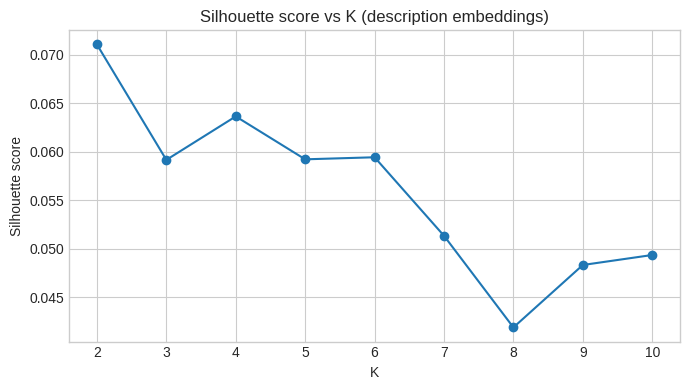


 Best K by silhouette: 2

Cluster sizes (non-empty descriptions only):
0    126
1    114
Name: count, dtype: int64

==================== CLUSTER SUMMARIES (DESCRIPTION-BASED) ====================


--- CLUSTER 0 ---
Total projects: 126
Example descriptions:
1. Lady Elliot Island Eco Resort actively practices regenerative tourism through a multi-faceted approach to environmental restoration.  The resort has been the site of a multi-year project to restore the island's terrestrial ecosystem, supported by par
2. The Tourism CoLab it's online education platform and global community of regenerative tourism practitioners.  Tourism CoLab's approach to regenerative tourism focuses on building the capacity of communities, businesses, and governments to collaborati
3. The Islander Way is a regenerative tourism project focused on Flinders Island, Australia. The project aims to co-design the future of tourism with the community, creating a system that respects their values, builds a resilient eco

In [117]:

TEXT_COL = "short description"

# Clean descriptions
df[TEXT_COL] = (
    df[TEXT_COL]
      .fillna("")
      .astype(str)
      .str.strip()
)

# Keep mask of non-empty descriptions (we can't embed empty strings meaningfully)
mask_nonempty = df[TEXT_COL].str.len() > 0
texts = df.loc[mask_nonempty, TEXT_COL].tolist()

print(f"Total rows: {len(df)}")
print(f"Rows with non-empty descriptions: {len(texts)}")


# EMBEDDINGS WITH SENTENCE-TRANSFORMERS


model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(
    texts,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print("Embeddings shape:", embeddings.shape)


#  FIND GOOD K (NUMBER OF CLUSTERS)


K_values = range(2, 11)
sil_scores = []

for k in K_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels_k = km.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels_k, metric="cosine")
    sil_scores.append(score)
    print(f"K={k}: silhouette={score:.3f}")


plt.figure(figsize=(7, 4))
plt.plot(list(K_values), sil_scores, "o-")
plt.title("Silhouette score vs K (description embeddings)")
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.tight_layout()
plt.show()


best_k = list(K_values)[int(np.argmax(sil_scores))]
print("\n Best K by silhouette:", best_k)

# FINAL KMEANS CLUSTERING


kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=50)
cluster_labels = kmeans.fit_predict(embeddings)

# Create a full-length array with NaN for empty descriptions
df["cluster_desc"] = np.nan
df.loc[mask_nonempty, "cluster_desc"] = cluster_labels

print("\nCluster sizes (non-empty descriptions only):")
print(pd.Series(cluster_labels).value_counts().sort_index())



print("\n==================== CLUSTER SUMMARIES (DESCRIPTION-BASED) ====================\n")

MAX_EXAMPLES = 5

for c in sorted(pd.Series(cluster_labels).unique()):
    cl_idx = np.where(cluster_labels == c)[0]
    print(f"\n--- CLUSTER {c} ---")
    print(f"Total projects: {len(cl_idx)}")
    print("Example descriptions:")

    examples = df.loc[mask_nonempty, TEXT_COL].iloc[cl_idx].head(MAX_EXAMPLES)
    for i, text in enumerate(examples, start=1):
        print(f"{i}. {text[:250].replace('\n', ' ')}")
    print("------------------------------------------------------")


The description-based clustering approach also produced two distinct and highly interpretable clusters, confirming that regenerative tourism projects naturally separate into meaningful thematic groups when analyzed through their narrative descriptions. Compared to feature-based clustering, this method revealed even clearer ecological and conceptual boundaries.

The first description-based cluster is dominated by projects focused on marine, coastal, and island ecosystem regeneration. The example descriptions emphasize coral nurseries, reef restoration, island ecosystem recovery, partnerships with marine scientists, and tourism models that directly support ocean conservation activities. This cluster captures initiatives where regenerative tourism functions as a mechanism for restoring underwater biodiversity, strengthening reef resilience, and protecting fragile coastal environments. The thematic coherence of this cluster indicates that marine-oriented projects share highly consistent language and conceptual framing.   

The second description-based cluster is centered on land-based restoration, rewilding, regenerative agriculture, and cultural landscape stewardship. The projects in this cluster frequently describe soil regeneration, wildlife habitat enhancement, expansion of protected lands, Indigenous land management practices, and strong community engagement. These narratives focus on restoring terrestrial ecosystems, supporting native species, and strengthening social-ecological resilience at the landscape level. The presence of cultural and community dimensions is particularly pronounced, reflecting the holistic approach typical of regenerative land management.

Overall, the description-based clustering reveals two robust thematic domains within regenerative tourism narratives:
(1) marine and island ecosystem restoration, and
(2) land and cultural landscape regeneration.

This confirms that the textual content of project descriptions contains strong semantic structure, allowing the model to differentiate between marine-focused and land-focused restoration approaches. The coherence of these clusters supports the validity of the description-based method and reinforces the ecological distinctions observed in the feature-based clustering.

# Semantic analisys

Total rows: 273
Non-empty descriptions: 240
TF-IDF shape: (240, 1942)
LSA matrix shape: (240, 4)

--- TOPIC 0 ---
local, tourism, community, conservation, regenerative, regenerative tourism, environment, marine, resort, sustainable, like, lodge, initiatives, projects, visitors

--- TOPIC 1 ---
tourism, regenerative, regenerative tourism, experiences, travel, positive, approach, visitors, positive impact, impact, global, tours, model, led, place

--- TOPIC 2 ---
marine, coral, resort, reef, marine life, conservation, efforts, tourism, islands, life, reefs, camp, turtle, project, restoration

--- TOPIC 3 ---
native, planting, habitat, tree, hawaiian, lodge, projects, visitors, degraded, tourists, tree planting, park, trees, species, reserve

Sample topic loadings:
    topic_0   topic_1   topic_2   topic_3
0  0.626391 -0.562706 -0.538621  0.029733
1  0.754608 -0.107412 -0.327087  0.558608
2  0.861804 -0.263110 -0.379141  0.210522
3  0.812221 -0.137441  0.542671 -0.164061
4  0.604377  0.78

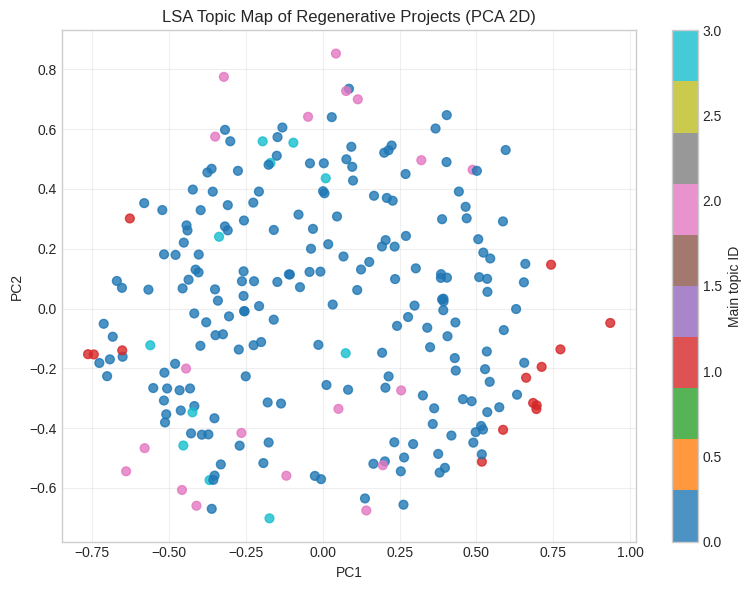

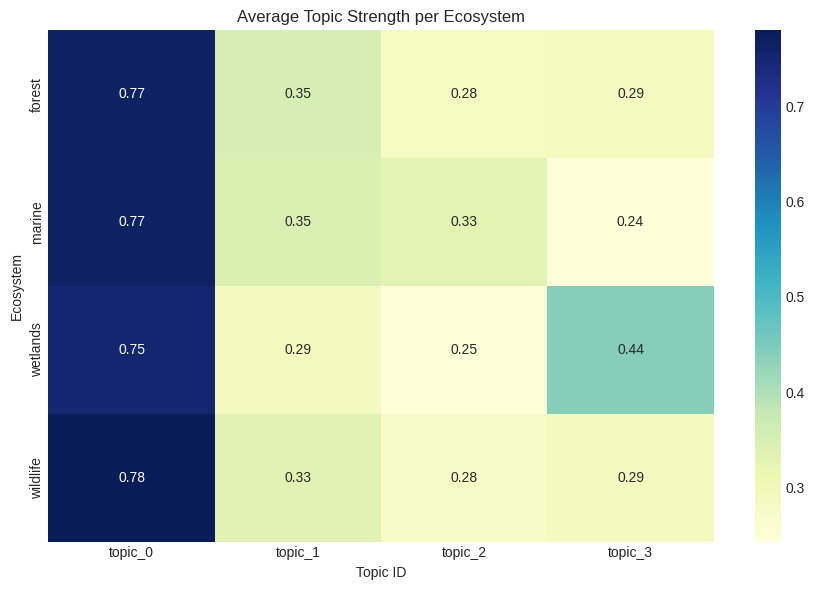

In [132]:
TEXT_COL = "short description"
ECO_COL = "ecosystem_group"
N_TOPICS = 4

#  PREPARE TEXT

df[TEXT_COL] = (
    df[TEXT_COL]
      .fillna("")
      .astype(str)
      .str.strip()
)

mask_nonempty = df[TEXT_COL].str.len() > 0
texts = df.loc[mask_nonempty, TEXT_COL].tolist()

print("Total rows:", len(df))
print("Non-empty descriptions:", len(texts))

#  TF-IDF + LSA

vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2
)

tfidf_matrix = vectorizer.fit_transform(texts)
print("TF-IDF shape:", tfidf_matrix.shape)

svd = TruncatedSVD(n_components=N_TOPICS, random_state=42)
lsa_matrix = svd.fit_transform(tfidf_matrix)
lsa_matrix_norm = Normalizer(copy=False).fit_transform(lsa_matrix)

print("LSA matrix shape:", lsa_matrix.shape)

terms = vectorizer.get_feature_names_out()

def print_top_words(svd_model, terms, n_words=15):
    for idx, component in enumerate(svd_model.components_):
        top_idx = component.argsort()[::-1][:n_words]
        top_terms = [terms[i] for i in top_idx]
        print(f"\n--- TOPIC {idx} ---")
        print(", ".join(top_terms))

print_top_words(svd, terms, n_words=15)

#  SAVE TOPIC LOADINGS BACK TO DF

topic_cols = [f"topic_{i}" for i in range(N_TOPICS)]

# LSA topics as DataFrame, aligned with df indices (only non-empty descriptions)
lsa_df = pd.DataFrame(
    lsa_matrix,
    index=df.index[mask_nonempty],
    columns=topic_cols
)

# Ensure columns exist in df and fill them
for col in topic_cols:
    df[col] = np.nan

df.loc[mask_nonempty, topic_cols] = lsa_df.values

print("\nSample topic loadings:")
print(df.loc[mask_nonempty, topic_cols].head())

#  TOPIC MAP (2D SCATTER)

pca = PCA(n_components=2, random_state=42)
lsa_2d = pca.fit_transform(lsa_matrix_norm)

# Main topic per project = index of max absolute loading
main_topic = np.argmax(np.abs(lsa_matrix), axis=1)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    lsa_2d[:, 0],
    lsa_2d[:, 1],
    c=main_topic,
    cmap="tab10",
    s=40,
    alpha=0.8
)

plt.title("LSA Topic Map of Regenerative Projects (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
cbar = plt.colorbar(scatter)
cbar.set_label("Main topic ID")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ECOSYSTEM × TOPIC HEATMAP

def parse_ecosystems(x):
    """Split ecosystem_group into clean labels, dropping empty and 'unknown'."""
    if not isinstance(x, str):
        return []
    parts = [
        p.strip().lower()
        for p in x.split(",")
        if p.strip() and p.strip().lower() != "unknown"
    ]
    return parts


eco_mask = (
    df[ECO_COL].astype(str).str.strip().ne("") &
    df[ECO_COL].astype(str).str.strip().str.lower().ne("unknown")
)

valid_mask = mask_nonempty & eco_mask
valid_indices = df.index[valid_mask]

eco_expanded = []

for idx in valid_indices:
    ecos_raw = df.at[idx, ECO_COL]
    ecos = parse_ecosystems(ecos_raw)

    if not ecos:
        continue

    topic_row = lsa_df.loc[idx].abs()  # absolute topic strengths

    for eco in ecos:
        row_dict = {"ecosystem": eco}
        row_dict.update(topic_row.to_dict())
        eco_expanded.append(row_dict)

eco_df = pd.DataFrame(eco_expanded)

# Compute mean topic strength per ecosystem
heat = eco_df.groupby("ecosystem")[topic_cols].mean()

plt.figure(figsize=(1.5 * N_TOPICS + 3, 6))
sns.heatmap(
    heat,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu"
)
plt.title("Average Topic Strength per Ecosystem")
plt.xlabel("Topic ID")
plt.ylabel("Ecosystem")
plt.tight_layout()
plt.show()


 Results : ECOSYSTEM × TOPIC HEATMAP FAILED

# WORD CLOUDS PER TOPIC

Total rows: 273
Non-empty descriptions: 240
TF-IDF shape: (240, 1942)
LSA matrix shape: (240, 4)

--- TOPIC 0 ---
local, tourism, community, conservation, regenerative, regenerative tourism, environment, marine, resort, sustainable, like, lodge, initiatives, projects, visitors

--- TOPIC 1 ---
tourism, regenerative, regenerative tourism, experiences, travel, positive, approach, visitors, positive impact, impact, global, tours, model, led, place

--- TOPIC 2 ---
marine, coral, resort, reef, marine life, conservation, efforts, tourism, islands, life, reefs, camp, turtle, project, restoration

--- TOPIC 3 ---
native, planting, habitat, tree, hawaiian, lodge, projects, visitors, degraded, tourists, tree planting, park, trees, species, reserve
Saved topic_1_wordcloud.png


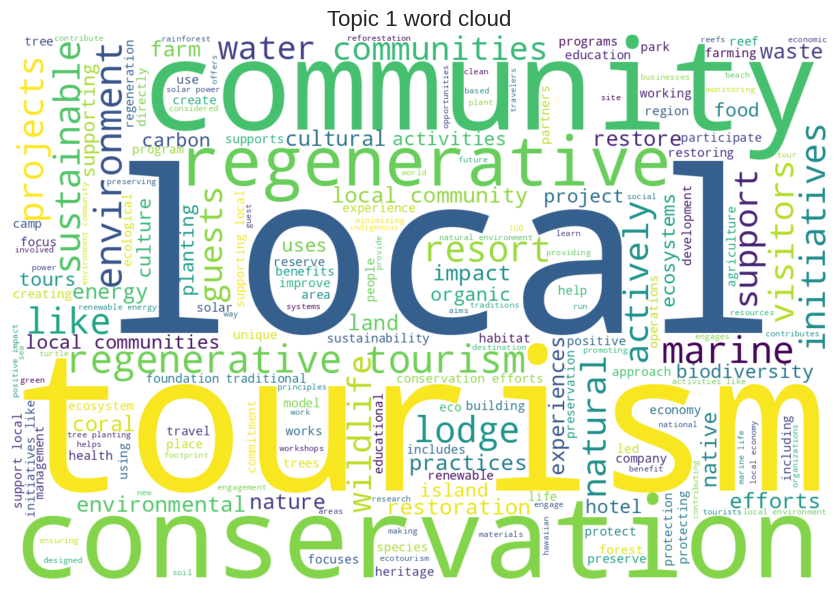

Saved topic_2_wordcloud.png


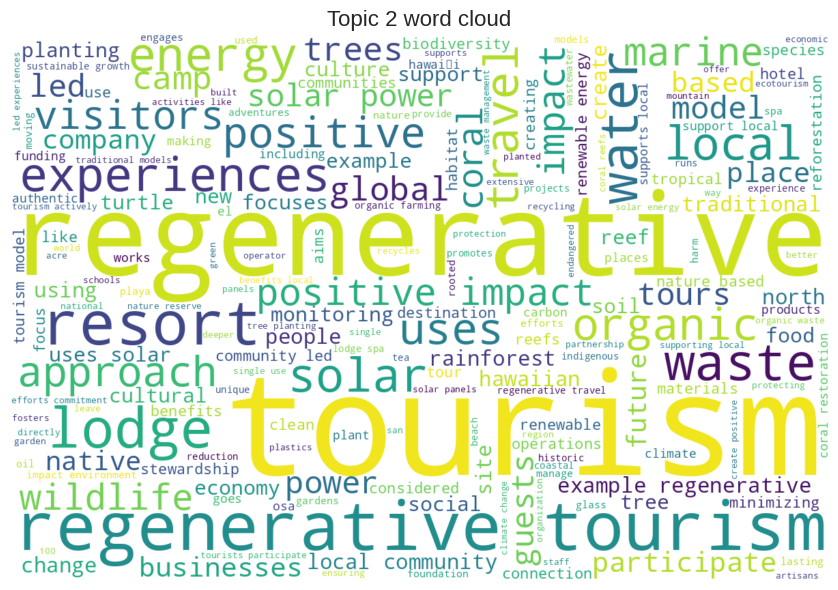

Saved topic_3_wordcloud.png


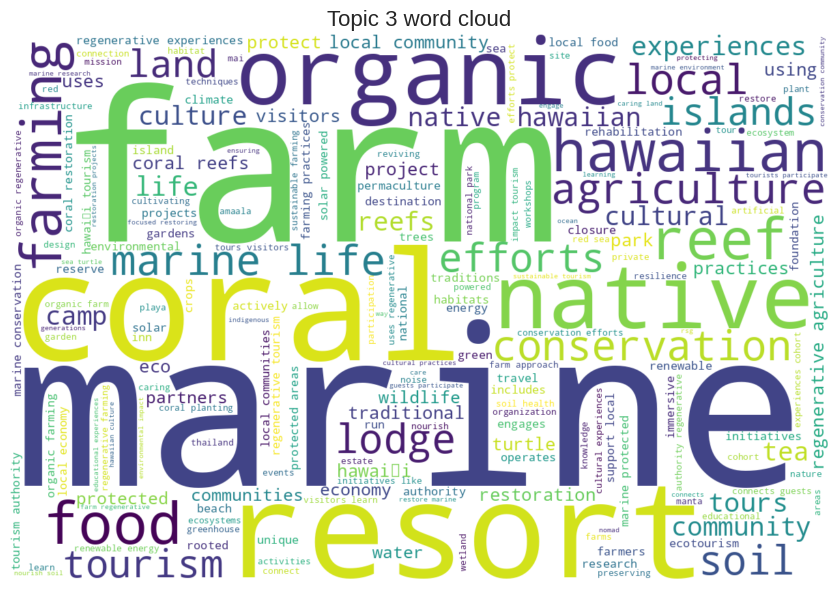

Saved topic_4_wordcloud.png


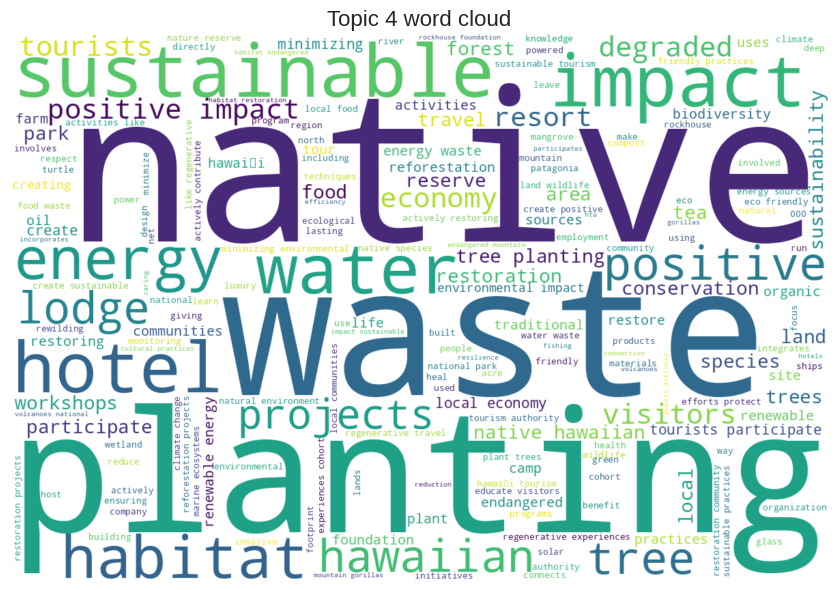

In [129]:
# CONFIG

TEXT_COL = "short description"
N_TOPICS = 4


#  PREPARE TEXT


df[TEXT_COL] = (
    df[TEXT_COL]
      .fillna("")
      .astype(str)
      .str.strip()
)

mask_nonempty = df[TEXT_COL].str.len() > 0
texts = df.loc[mask_nonempty, TEXT_COL].tolist()

print("Total rows:", len(df))
print("Non-empty descriptions:", len(texts))


#  TF-IDF + LSA


vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2,
)

tfidf_matrix = vectorizer.fit_transform(texts)
print("TF-IDF shape:", tfidf_matrix.shape)

svd = TruncatedSVD(n_components=N_TOPICS, random_state=42)
lsa_matrix = svd.fit_transform(tfidf_matrix)
lsa_matrix_norm = Normalizer(copy=False).fit_transform(lsa_matrix)

print("LSA matrix shape:", lsa_matrix.shape)

terms = vectorizer.get_feature_names_out()


#  PRINT TOP WORDS (OPTIONAL)


def print_top_words(svd_model, terms, n_words=15):
    for idx, component in enumerate(svd_model.components_):
        top_idx = component.argsort()[::-1][:n_words]
        top_terms = [terms[i] for i in top_idx]
        print(f"\n--- TOPIC {idx} ---")
        print(", ".join(top_terms))

print_top_words(svd, terms, n_words=15)


# svd.components_ has shape (N_TOPICS, n_terms)
components = svd.components_   # each row: topic → weights over terms

for topic_idx in range(N_TOPICS):
    comp = components[topic_idx]

    # Build {word: weight} dict – use abs() so negative loadings also appear
    word_weights = {terms[i]: float(abs(comp[i])) for i in range(len(terms))}

    # Generate word cloud
    wc = WordCloud(
        width=1200,
        height=800,
        background_color="white"
    ).generate_from_frequencies(word_weights)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_idx+1} word cloud", fontsize=16)
    plt.tight_layout()

    # Save to file
    out_name = f"topic_{topic_idx+1}_wordcloud.png"
    plt.savefig(out_name, dpi=200)
    print(f"Saved {out_name}")

    plt.show()


🌍 Topic 1 — Community-Centered Regenerative Tourism
Short Description:

Projects emphasizing local communities, conservation values, environmental protection, and regenerative principles. Narratives often highlight collaboration, community benefits, and the integration of tourism with sustainability practices.

Evaluation:

A broad but meaningful “core regenerative tourism” topic. Captures the social + environmental foundations of regenerative projects. Strong coherence and expected centrality.

✈️ Topic 2 — Tourism Experiences & Positive Impact Model
Short Description:

Projects that frame regenerative tourism through visitor experiences, travel activities, guided tours, and models emphasizing “positive impact.” The language here is more experiential, touristic, and customer-facing.

Evaluation:

A distinct “tourism product / experience” dimension. Shows how regenerative concepts are communicated to travelers. Good separation from Topic 0: more marketing/experience-driven, less community/ecology oriented.

🌊 Topic 3 — Marine & Coral Reef Restoration
Short Description:

Projects focused on coral reefs, marine wildlife, restoration activities, turtle conservation, reef health, and island ecosystems. Strongly connected to ocean-based regenerative tourism.

Evaluation:

An extremely coherent ecological topic. Clean separation, very strong semantic focus. This aligns with your other clustering results and confirms the marine restoration domain as one major global pathway.

🌱 Topic 4 — Native Species, Habitat Restoration & Reforestation
Short Description:

Projects describing native species protection, habitat recovery, tree planting, ecosystem rehabilitation, and terrestrial biodiversity restoration—often involving degraded landscapes, parks, or reserves.

Evaluation:

A clear and highly meaningful terrestrial restoration topic. Strong ecological coherence, directly complementary to the marine topic. Matches your feature-based clustering and reinforces the “land regeneration” global trend.

⭐ Final Insight

These four topics form a natural semantic structure:

Community / conservation values

Tourism experiences & positive impact framing

Marine ecological restoration

Terrestrial regeneration & native species restoration

Together they capture the social, experiential, marine, and land-based dimensions of regenerative tourism worldwide.

